In [1]:
import numpy as np
import tritonclient.http

In [2]:
# model
model_name = "stable_diffusion"
url = "0.0.0.0:8000"
model_version = "1" 
batch_size = 1

In [3]:
# model input params
prompt = "a photo of an astronaut riding a horse on mars"
negative_prompt = "NONE" # replace NONE with actual negative prompt if any
samples = 1 # no.of images to generate
steps = 50
guidance_scale = 7.5
seed = 1024

In [4]:
triton_client = tritonclient.http.InferenceServerClient(url=url, verbose=False)
assert triton_client.is_model_ready(
    model_name=model_name, model_version=model_version
), f"model {model_name} not yet ready"

model_metadata = triton_client.get_model_metadata(model_name=model_name, model_version=model_version)
model_config = triton_client.get_model_config(model_name=model_name, model_version=model_version)

In [5]:
# Input placeholder
prompt_in = tritonclient.http.InferInput(name="PROMPT", shape=(batch_size,), datatype="BYTES")
negative_prompt_in = tritonclient.http.InferInput(name="NEGATIVE_PROMPT", shape=(batch_size,), datatype="BYTES")
samples_in = tritonclient.http.InferInput("SAMPLES", (batch_size, ), "INT32")
steps_in = tritonclient.http.InferInput("STEPS", (batch_size, ), "INT32")
guidance_scale_in = tritonclient.http.InferInput("GUIDANCE_SCALE", (batch_size, ), "FP32")
seed_in = tritonclient.http.InferInput("SEED", (batch_size, ), "INT64")

images = tritonclient.http.InferRequestedOutput(name="IMAGES", binary_data=False)

In [6]:
%%time
# Setting inputs
prompt_in.set_data_from_numpy(np.asarray([prompt] * batch_size, dtype=object))
negative_prompt_in.set_data_from_numpy(np.asarray([negative_prompt] * batch_size, dtype=object))
samples_in.set_data_from_numpy(np.asarray([samples], dtype=np.int32))
steps_in.set_data_from_numpy(np.asarray([steps], dtype=np.int32))
guidance_scale_in.set_data_from_numpy(np.asarray([guidance_scale], dtype=np.float32))
seed_in.set_data_from_numpy(np.asarray([seed], dtype=np.int64))

response = triton_client.infer(
    model_name=model_name, model_version=model_version, 
    inputs=[prompt_in,negative_prompt_in,samples_in,steps_in,guidance_scale_in,seed_in], 
    outputs=[images]
)

CPU times: user 115 ms, sys: 34.9 ms, total: 150 ms
Wall time: 2.38 s


In [7]:
images = response.as_numpy("IMAGES")

In [8]:
from PIL import Image

In [9]:
if images.ndim == 3:
    images = images[None, ...]
images = (images * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

In [10]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

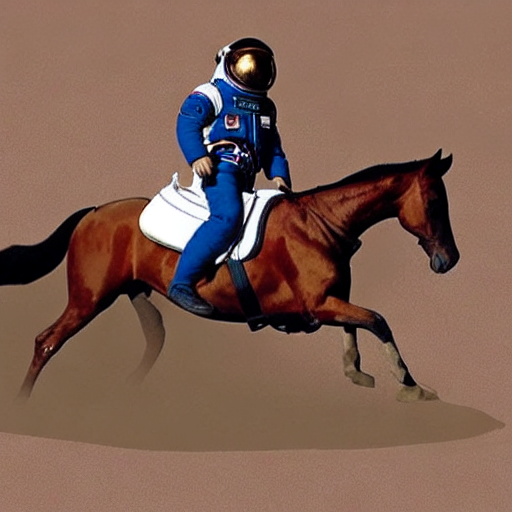

In [11]:
rows = 1 # change according to no.of samples 
cols = 1 # change according to no.of samples
# rows * cols == no.of samples
image_grid(pil_images, rows, cols)